# Neural Network that solves the Heat Equation
 The objective of this notebook is to create a NN that solves the heat equation with a certain initial value and boundary conditions in an interval $[-1,1]$ for a time interval $[0,T]$.

 * Define the network class with a loss function that solves the heat equation. leave room for initial condition and boundary condition loss terms?
 * Write functions that train and validate the network.
 * Write functions that plot the solution and the loss over the pochs
 * Define the training data in the domain.
 * Instantiate and train a baseline network. Validate it.
 * cross val with different architectures

In [1]:
# Torch imports
import torch

import torch.autograd as autograd # computation graph
from torch import Tensor # tensor node in the computation graph
import torch.nn as nn # Neural networks
import torch.optim as optiom # Optimizer, gradient descen adam, etc.

# Other Imports
import numpy as np 
import matplotlib.pyplot as plt


## Problem definition
We want to solve the heat equation in an interval of $\mathbb{R}$
$$u_t(x,t) = u_{xx}(x,t) \qquad (x,t) \in [-1,1]\times [0,4]$$
$$u(x,0) = u_0(x) \qquad\forall x\in [-1,1]  $$
and a certain boundary condition.

We proprose a Physics Informed Neural Network $\psi_{NN}(x,t)$ and a loss function composed of 4 terms.

* $L_1 = ||\psi_{NN}(x,0)  - u_0 (x) ||_2$
* $L_2 = ||\psi_{NN}(-1,t)  - 0||_2$
* $L_3 = ||\psi_{NN}(1,t)  - 0||_2$
* $L_4 = ||\psi_{NN}(x,t)_t - \psi_{NN}(x,t)_{xx}||_2$

So our Loss function will be
$$L(\psi) := L_1(\psi) + L_2(\psi) + L_3(\psi) + L_4(\psi)$$

Of course since we can't compute exactly these $L^2$ norms, we will aproximate them with sums over some points of the domain

* $L_1 = \frac{1}{n_1}  \sum_{k=1}^{n_1} | \psi_{NN}(x_k,0)  - u_0 (x_k)|^2 $
* $L_2 = \frac{1}{n_2}  \sum_{k=1}^{n_2} | \psi_{NN}(-1,t_k) |^2 $
* $L_2 = \frac{1}{n_3}  \sum_{k=1}^{n_3} | \psi_{NN}(1,t_k) |^2 $
* $L_4 = \frac{1}{N_4}  \sum_{i=1}^{n_4} | \psi_{NN,t}((x,t)_i) - \psi_{NN,xx} ((x,t)_i) |^2 $

For some data points
* $\{x_k \}_{k=1}^{n_1}$ is a partition of $[-1,1]$. We may choose it randomly or just take a grid with a fixed step.
* Same for $\{t_k \}_{k=1}^{n_2}$ in $[0,T]$
* $\{(x,t)_i \}_{i=1}^{n_4}$ are the collocation points inside the domain that we choose randomly



## Data

We will create all of the points we will need, including a small validation data set

In [56]:
# We define our domain as $[-1,1] x [0,4]$
xm = -1
xM = 1
t0 = 0 # t siempre empieza en cero
T = 4

number_of_points = 10000

# (X, T)

#Initial condition
x_init_train = torch.linspace(xm,xM,number_of_points)
y_init_train = np.exp(-x_init_train**2 )- 1/np.e

# Reshape x
x_init_train = torch.reshape(x_init_train, (number_of_points, 1))
t_zeros = torch.zeros(number_of_points)
t_zeros = torch.reshape(t_zeros, (number_of_points,1))
x_init_train = torch.cat((x_init_train,t_zeros),dim = 1)

# Reshape y
y_init_train = torch.reshape(y_init_train, (number_of_points,1))

#Boundary condition
t_bc= torch.linspace(t0,T,number_of_points)
t_bc = torch.reshape(t_bc, (number_of_points,1))

x_bc = torch.ones(number_of_points)
x_bc = torch.reshape(x_bc,(number_of_points,1))

t_bc1_train = torch.cat((-1*x_bc,t_bc), dim = 1)
t_bc2_train = torch.cat((x_bc, t_bc), dim = 1)

#y_bc1_train = torch.ones((t_bc1_train.shape[0],1))
#y_bc2_train = torch.ones((t_bc2_train.shape[0],1))
y_bc1_train = torch.zeros((t_bc1_train.shape[0],1))
y_bc2_train = torch.zeros((t_bc2_train.shape[0],1))



t_bc_train = torch.cat((t_bc1_train, t_bc2_train), dim = 0)
y_bc_train = torch.cat((y_bc1_train, y_bc2_train), dim = 0)



Text(0.5, 1.0, 'Initial condition')

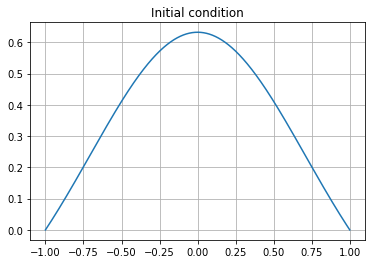

In [60]:
plt.plot(x_init_train[:,0], y_init_train)
plt.grid()
plt.title("Initial condition")

In [43]:
x_init_train[0:10], y_init_train[:10]

(tensor([[-1.0000,  0.0000],
         [-0.9998,  0.0000],
         [-0.9996,  0.0000],
         [-0.9994,  0.0000],
         [-0.9992,  0.0000],
         [-0.9990,  0.0000],
         [-0.9988,  0.0000],
         [-0.9986,  0.0000],
         [-0.9984,  0.0000],
         [-0.9982,  0.0000]]),
 tensor([[0.0000],
         [0.0001],
         [0.0003],
         [0.0004],
         [0.0006],
         [0.0007],
         [0.0009],
         [0.0010],
         [0.0012],
         [0.0013]]))

In [75]:
aux = x_init_train.detach().numpy()
import pandas as pd
df = pd.DataFrame(aux)
df[0].unique()

10000

In [61]:
# Colocation points
number_of_points = 10000

x_coloc_train = xm + (xM-xm)*torch.rand(number_of_points)
t_coloc_train = T*torch.rand(number_of_points)

x_coloc_train = torch.reshape(x_coloc_train,(number_of_points,1))
t_coloc_train = torch.reshape(t_coloc_train,(number_of_points,1))

X_coloc_train = torch.cat((x_coloc_train,t_coloc_train), dim = 1)
#X_coloc_train[0:10], X_coloc_train.shape


In [45]:
X_coloc_train[:10]

tensor([[ 0.5095,  0.4620],
        [ 0.3071,  2.8291],
        [-0.0342,  2.6427],
        [ 0.6851,  0.7372],
        [ 0.5265,  0.1360],
        [ 0.0235,  2.1725],
        [-0.9542,  1.5141],
        [-0.1012,  3.9345],
        [-0.3016,  3.9449],
        [-0.6412,  0.2295]])

Tengo mis cuatro conjuntos de puntos para evaluar la loss

* x_init_train
* y_init_train
* t_bc1_train
* t_bc2_train
* X_coloc_train

OJO CON `t_bc_train` !!!!

No hize los vectores de ceros como los y de la boundary ocnidtion, pero ese total lo puedo ahcer despues

Me gustaria funcionalizar la manera como hago estos puntos.


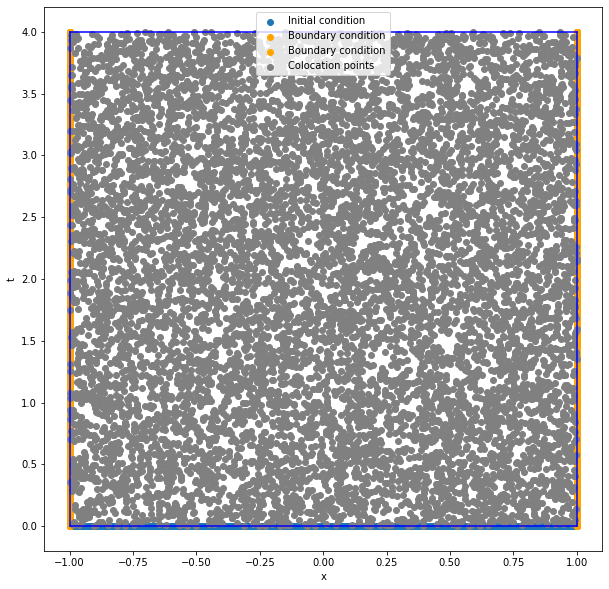

In [62]:
# Graficamos los puntos
fig, ax = plt.subplots(figsize = (10,10))

ax.set_xlabel("x")
ax.set_ylabel("t")

# Plot the domain
ax.plot([xm,xM],[0,0], color = 'blue')
ax.plot([xm,xm],[0,T], color = 'blue')
ax.plot([xM,xM],[0,T], color = 'blue')
ax.plot([xm,xM],[T,T], color = 'blue')

#plot ic
plt.scatter(x_init_train[:,0], x_init_train[:,1], label = "Initial condition")

#plot bc
plt.scatter(t_bc1_train[:,0], t_bc1_train[:,1], label = "Boundary condition", color = "orange")
plt.scatter(t_bc2_train[:,0], t_bc2_train[:,1], label = "Boundary condition", color = "orange")

# Plot Collocation points
plt.scatter(X_coloc_train[:,0], X_coloc_train[:,1], label = "Colocation points", color = "gray")

ax.legend()

## Instantiating
We have the data and we have created our pinn class. Let's instantiate it along with an optimizer and get everything ready for training.




In [47]:
from pinn import PINN

layers = [2,30,30,30,30,1]

fnn = PINN(layers)


# Optimizer
lr = 1e-3
optimizer = torch.optim.SGD(fnn.parameters(), lr = lr)


## Training


In [48]:
%%time

torch.manual_seed(42)

epochs = 1000
number_of_batches = 10

n_ic = len(x_init_train)
n_bc = len(t_bc_train) #Atencion. Esto lo estoy atando con alambras porque estoy uniendo toda al bc junto
n_coloc = len(x_coloc_train)

batch_size_ic = int(n_ic/number_of_batches)
batch_size_bc = int(n_bc/number_of_batches)
batch_size_coloc = int(n_coloc/number_of_batches)

epoch_number = []
epoch_loss = []


for ep in range(epochs):
    if ep%(epochs/10) == 0:
        print("entre")
    #Randomize the indexes to construct the batches
    indexes_ic = torch.randperm(n_ic)
    indexes_bc = torch.randperm(n_bc)
    indexes_coloc = torch.randperm(n_coloc)

    for k in range(number_of_batches):
        batch_index_ic = indexes_ic[k * batch_size_ic : (k+1)*batch_size_ic]
        batch_index_bc = indexes_bc[k * batch_size_bc : (k+1) * batch_size_bc]
        batch_index_coloc = indexes_coloc[k * batch_size_coloc : (k+1) * batch_size_coloc]

        # Entreno 
        # #ciclo clasico de pytorch.
        
        # Reset gradients to zero
        optimizer.zero_grad()

        # Prepare data
        X_init_batch = x_init_train[batch_index_ic]
        y_init_batch = y_init_train[batch_index_ic]

        X_bc_batch = t_bc_train[batch_index_bc]
        y_bc_batch = y_bc_train[batch_index_bc]        
        
        X_coloc_batch = X_coloc_train[batch_index_coloc]

        # Evaluate loss function on batch data
        loss = fnn.loss(X_ic = X_init_batch, 
                        y_ic = y_init_batch, 
                        X_bc = X_bc_batch, 
                        y_bc = y_bc_batch, 
                        X_coloc = X_coloc_batch)

        # Calculate gradients and update parameters.
        loss.backward()
        
        optimizer.step()

    #anoto la loss para graficar #onedb para logear
    if ep%(epochs/100) == 0:
        epoch_loss.append(loss)
        epoch_number.append(ep)
    if ep%(epochs/10) == 0:
        print(ep, loss)
        #entreno

entre
0 tensor(0.2390, grad_fn=<AddBackward0>)
entre
100 tensor(0.0664, grad_fn=<AddBackward0>)
entre
200 tensor(0.0615, grad_fn=<AddBackward0>)
entre
300 tensor(0.0581, grad_fn=<AddBackward0>)
entre
400 tensor(0.0553, grad_fn=<AddBackward0>)
entre
500 tensor(0.0552, grad_fn=<AddBackward0>)
entre
600 tensor(0.0538, grad_fn=<AddBackward0>)
entre
700 tensor(0.0534, grad_fn=<AddBackward0>)
entre
800 tensor(0.0500, grad_fn=<AddBackward0>)
entre
900 tensor(0.0500, grad_fn=<AddBackward0>)
CPU times: user 7min 25s, sys: 9min 17s, total: 16min 43s
Wall time: 2min 39s


## Plotting

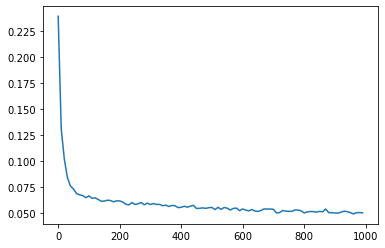

In [49]:
plt.plot(epoch_number,[el.detach().numpy() for el in epoch_loss])

In [50]:
x_plot = np.linspace(-1,1,100)
t_plot = np.linspace(0,4,100)
x_plot, t_plot = np.meshgrid(x_plot, t_plot)

#Lo que necesito es una lista de listas Z que en la posicion Z[i,j] tenga el valor de la superficie en X[i][j] Y[i][j]

zv=[[1 for j in range(len(t_plot))] for i in range(len(x_plot)) ]

for i in range(len(x_plot)):
    for j in range(len(t_plot)):
        #print(np.array([xt[0][i][j],xt[1][i][j]]))
        aux = fnn(np.array( [x_plot[i][j], t_plot[i][j]] ))
        #zv[i][j] = aux.detach().numpy()[0]
        zv[i][j] = aux.detach().numpy()[0]
        #superficie(xt[0][i][j],xt[1][i][j])
print(t_plot.shape)
zv = np.array(zv, dtype = "float64")
zv.shape
#zv


(100, 100)


(100, 100)

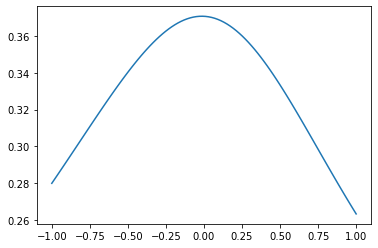

In [51]:
index = 0
plt.plot(np.linspace(-1,1,len(zv[0])), zv[:][index])
plt.xlim = [-1,1]
plt.ylim= [0,0.5]
plt.show()

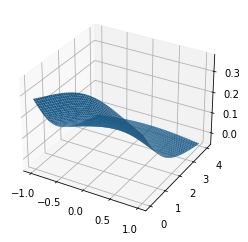

In [52]:
from mpl_toolkits.mplot3d import Axes3D

#fig = plt.figure()
ax = plt.axes(projection='3d')

x_plot = np.linspace(-1,1,100)
t_plot = np.linspace(0,4,100)
X, Y = np.meshgrid(x_plot, t_plot)

ax.plot_surface(X, Y, zv)
plt.show()

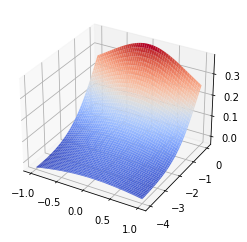

In [38]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

ax = plt.axes(projection="3d")

new_x = np.linspace(-1,1,100)
new_t = -1*np.linspace(0,4,100)
X,Y  = np.meshgrid(new_x, new_t)

ax.plot_surface(X, Y, zv, cmap="coolwarm")


plt.show()

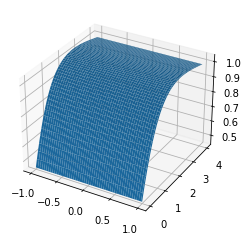

In [154]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = plt.axes(projection="3d")

# Make data.
#X = np.linspace(-5, 5, 100)
#Y = np.linspace(-5, 5, 100)
#X, Y = np.meshgrid(X, Y)
#R = np.sqrt(X**2 + Y**2)
#Z = np.sin(R)


new_x = np.linspace(-1,1,100)
new_t = np.linspace(0,4,100)
X, Y = np.meshgrid(new_x, new_t)
# Plot the surface.
#surf = ax.plot_surface(X, Y, zv, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)
ax.plot_surface(X, Y, zv)#, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Res

# Por hacer
* hacer una clase dataset que haga el dominio y lo pase al shape correcto y haga tambien un validation set. Que inlcuya un metodo para graficar, igual qeu el chabon del sciann
* Escribir la calse pinn. Hecho. Reescribirla dejando dejando lugar para la loss. La idea seria que haga una subclasse tipo el sciann que le pase la loss y se encargue tambien del training


possible improvements:
* change activation function from Tanh to relu or something else. Should run experiments.
* Is there an activation function that is already what people use for pinns?
* How to escalte each term of the loss function? Watch the video of the dr from the uk again.

## Dudas
Acá tengo dudas
* Por lo que estoy entendiendo, el autograd.grad está pensado para que lo uses con inputs y outputs escalares. Es decir, le pasas una f(x) que toma x escalar y devuelve f escalar y te calcula la derivada de f con respecto a x.
    
    Entonces, para que yo le pase mi vector X de inputs y mi vector F de outputs y todo funcione, le tengo que poner el grad_outputs como un vector de ONES para que me haga la multiplicacion de vectores y me de el output que me sirve

    Como seria la manera de trabajar? Asi como estoy haciendo? Hay una manera de programar los datos de input y la loss para que cuando escriba la linea del autograd me tome onda un escalar? Vale la pena? Como se hace? Ampliaremos.

In [94]:
x = torch.Tensor(range(10)).reshape((10,1))
y = torch.Tensor(range(10,20)).reshape((10,1))

xt = torch.cat((x,y), dim = 1)
xt.requires_grad = True


In [95]:
z = xt[:,0].reshape((10,1)) * xt[:,1].reshape((10,1))
z

tensor([[  0.],
        [ 11.],
        [ 24.],
        [ 39.],
        [ 56.],
        [ 75.],
        [ 96.],
        [119.],
        [144.],
        [171.]], grad_fn=<MulBackward0>)

In [96]:
dz = autograd.grad(z,xt, grad_outputs = torch.ones(10,1), create_graph=True, retain_graph=True)[0]

In [97]:
dzx = dz[:,0].reshape((10,1))
dzy = dz[:,1].reshape((10,1))

In [98]:
print(autograd.grad(dzx, xt, grad_outputs = torch.ones(10,1), create_graph=True))
print(autograd.grad(dzy, xt, grad_outputs = torch.ones(10,1)))

(tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]),)
(tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]),)


In [99]:
len(z)


10